In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    implementPairDecayLimit,
    fromHB5Table1,
    read_csv_from_web,
    readHEPDataCsv,
    implementPairProductionLimit,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions
import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution

# W > mu/e nu from PDG 2020
b_W_lnu = 2 * 10.86e-2


# CMS 13TeV LHC

## `H > hSM hSM > bbWW` [1708.04188](https://arxiv.org/abs/1708.04188)


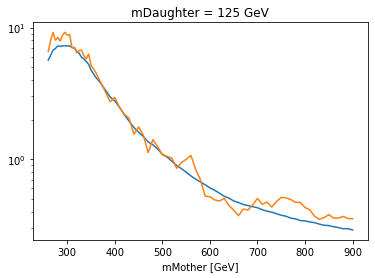

Looks good. Saving this to H_bbWW_LHC13_CMS_36.json


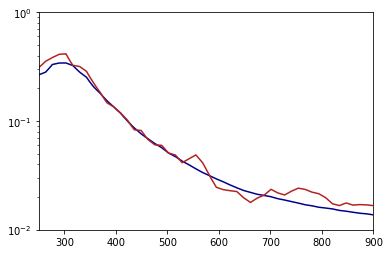

In [2]:
df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1615868/Figure%207a/1/csv",
    comment="#",
    skiprows=12,
    skipfooter=244 - 87,
    engine="python",
    names=["mMother", "obs", "unc+", "unc-"],
)

dfExp = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1615868/Figure%207a/1/csv",
    comment="#",
    skiprows=168,
    names=["m", "exp", "unc+", "unc-"],
)
assert np.allclose(df.mMother, dfExp.m)
del df["unc+"]
del df["unc-"]
df["exp"] = dfExp.exp
df.exp *= 1e-3 / b_W_lnu ** 2  # fb to pb and remove WW > llnunu decay
df.obs *= 1e-3 / b_W_lnu ** 2
df["mDaughter1"] = 125
limitFile = implementPairDecayLimit(
    "1708.04188",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["WW"],
    },
    "https://doi.org/10.17182/hepdata.83195.v1/t19",
    df,
    prefix="H_bbWW",
    massResolution={
        "firstDaughter": {"absolute": 30, "relative": 0},  # guess
        "secondDaughter": {"absolute": 30, "relative": 0},  # guess
        "mother": resolution.bb["highMass"],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1.0)
h2.setDecayWidth("WW", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(250, 900)
r = np.linspace(1e-2, 1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate / b_W_lnu ** 2)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## `H > hSM hSM > bbWW` [1708.04188](https://arxiv.org/abs/1708.04188)


In [2]:
df = pd.DataFrame({"m": [125], "obs": 72e-3, "exp": 81e-3})
df.obs /= b_W_lnu ** 2
df.exp /= b_W_lnu ** 2
limitFile = implementPairProductionLimit(
    "1708.04188",
    {"firstDecay": ["bb"], "secondDecay": ["WW"]},
    "p. 11",
    df,
    idSuffix=1,
    massResolution={  # guess +-15
        "firstParticle": {"absolute": 30, "relative": 0.0},
        "secondParticle": {"absolute": 30, "relative": 0.0},
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h2.setDecayWidth("WW", 1.0)
h2.setMass(125)
pred.setBsmPairCxn("LHC13", "h1", "h2", 1.0)
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_CMS_36.json
[<Higgs.bounds.AppliedLimit limitId: 1708041881, obsRatio: 0.655, expRatio: 0.582, for: ["h1", "+", "h2"]>]


## `H > hSM hSM > bb ZZ` [2006.06391](https://arxiv.org/abs/2006.06391)


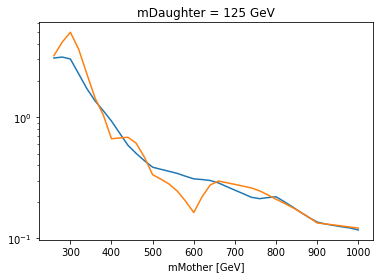

Looks good. Saving this to H_bbZZ_LHC13_CMS_36.json


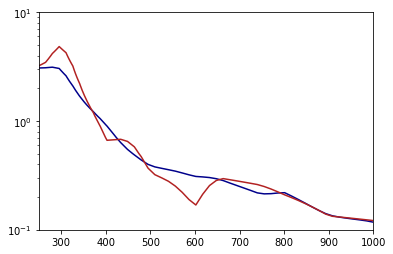

In [4]:
df = fromHB5Table1("18013_CMS_HH-bbZZ_35.9fb-1", "CMS").rename(columns={"m": "mMother"})
df["mDaughter1"] = 125
# the conf note version implemented in the old HB did not include the final decays
df.obs *= 2 * HP.SMHiggs(125).br("ZZ") * HP.SMHiggs(125).br("bb")
df.exp *= 2 * HP.SMHiggs(125).br("ZZ") * HP.SMHiggs(125).br("bb")

limitFile = implementPairDecayLimit(
    "2006.06391",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["ZZ"],
    },
    "Fig. 4 (left)",
    df,
    collider="LHC13",
    prefix="H_bbZZ",
    massResolution={
        "firstDaughter": {
            "absolute": 15,
            "relative": 0,
        },  # p 8 (llnunu, but the others are probably similar)
        "secondDaughter": {"absolute": 60, "relative": 0},  # p 8
        "mother": resolution.bb["highMass"],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1)
h2.setDecayWidth("ZZ", 1)
h1.setMass(125)
h2.setMass(100)
hm = np.linspace(250, 1000)
r = np.linspace(1e-1, 10)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## high mass `H > hSM hSM > bbWW` [1904.04193](https://arxiv.org/abs/1904.04193)

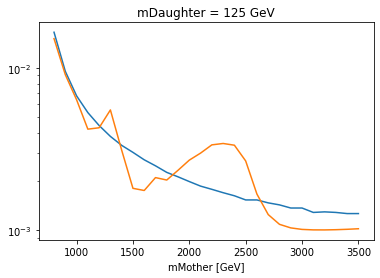

Looks good. Saving this to H_bbWW_highM_LHC13_CMS_36.json


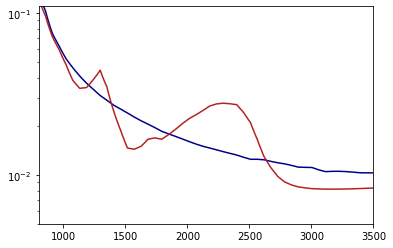

In [8]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1728701/Figure%207a/1/csv",
)
df = dfs[0].rename(
    columns={
        "X boson mass [GeV]": "mMother",
        "Observed 95% CL upper limits [fb]": "obs",
    }
)
df["exp"] = dfs[1]["Expected 95% CL upper limits [fb]"]
refBr = HP.SMHiggs(125).br("bb") * HP.SMHiggs(125).br("WW")
df.exp *= 1e-3 * refBr  # fb to pb and add hSM BRs
df.obs *= 1e-3 * refBr
df["mDaughter1"] = 125

limitFile = implementPairDecayLimit(
    "1904.04193",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["WW"],
    },
    "https://doi.org/10.17182/hepdata.88898.v1/t1",
    df,
    prefix="H_bbWW_highM",
    massResolution={
        "firstDaughter": {"absolute": 0, "relative": 0.1},  # p. 11
        "secondDaughter": {"absolute": 30, "relative": 0},  # guess
        "mother": {
            "absolute": 30,
            "relative": 0.03,
        },  # p 11 (bottom), probably assumes h125 masses
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1.0)
h2.setDecayWidth("WW", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(800, 3500)
r = np.linspace(5e-3, 0.11)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate * refBr)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## `X > hSM hSM > bbWW` [2112.03161](https://arxiv.org/abs/2112.03161)

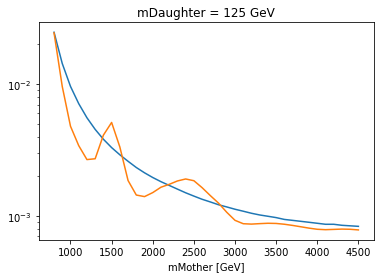

Looks good. Saving this to H_LHC13_CMS_138.json


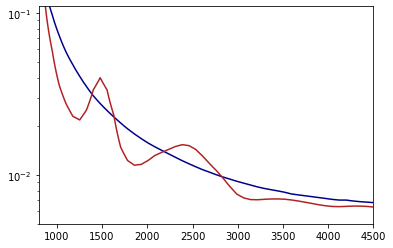

In [12]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1984855/Figure%207a/1/csv",
)
df = dfs[0].rename(
    columns={
        "Radion mass [GeV]": "mMother",
        "Cross section upper limit at 95% CL [pb]": "obs",
    }
)
df["exp"] = dfs[1]["Cross section upper limit at 95% CL [pb]"]
# df.exp *= 1e-3 * refBr  # fb to pb and add hSM BRs
# df.obs *= 1e-3 * refBr
df["mDaughter1"] = 125

limitFile = implementPairDecayLimit(
    "1984855",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["WW"],
    },
    "Fig.7(a)",
    df,
    massResolution={
        "firstDaughter": {"absolute": 6, "relative": 0.05},  
        "secondDaughter": {"absolute": 30, "relative": 0},  # guess
        "mother": {
            "absolute": 50,
            "relative": 0.05,
        },  # p 11 (bottom), probably assumes h125 masses
    },
)
lim = HB.Limit(limitFile)

refBr = HP.SMHiggs(125).br("bb") * HP.SMHiggs(125).br("WW")
pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1.0)
h2.setDecayWidth("WW", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(800, 4500)
r = np.linspace(5e-3, 0.11)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate * refBr)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
